In [65]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
from sklearn.decomposition import PCA

In [66]:
def load_ndarrays_from_hdf5(file_path, args):
    data = {}  # Use a nested dictionary to organize data by network_id and then by task condition
    data_pert = {}  # Use a nested dictionary to organize data by network_id and then by task condition
    body_comp_data = {}
    neuron_comp_data = {}
    with h5py.File(file_path, 'r') as f:
        spectral_radius = args.spectral_radiuses[0] + 0
        task_condition = args.task_condition
        spectral_radius_group = str(spectral_radius)  # Ensure the spectral radius is in the correct format
        for i in range(1):  # Assuming there are always 10 networks
            network_id = f'network_{i}'
            data[network_id] = {}  # Initialize a sub-dictionary for each network_id
            data_pert[network_id] = {}  # Initialize a sub-dictionary for each network_id
            body_comp_data[network_id] = {}
            neuron_comp_data[network_id] = {}
            for condition in task_condition:
                dataset_name = f'{spectral_radius_group}/{network_id}/{condition}/states'
                if dataset_name in f:
                    states = f[dataset_name][()][:, 0:1, :]
                    # Store the states in the nested dictionary under the corresponding network_id and condition
                    data[network_id][condition] = states
                    # mechanical perturbation data
                    states_pert = f[dataset_name][()][:, 2:3, :]
                    data_pert[network_id][condition] = states_pert
                else:
                    print(f"Dataset {dataset_name} not found.")

                # body composition data
                #dataset_name = f'{spectral_radius_group}/{network_id}/{condition}/all_body_components'
                #if dataset_name in f:
                #    body_comp_data[network_id][condition] = f[dataset_name][()][:, 0:1, :]
                #else:
                #    print(f"Dataset {dataset_name} not found.")
                
                ## neuron composition data
                #dataset_name = f'{spectral_radius_group}/{network_id}/{condition}/all_neural_components'
                #if dataset_name in f:
                #    neuron_comp_data[network_id][condition] = f[dataset_name][()][:, 0:1, :]
                #else:
                #    print(f"Dataset {dataset_name} not found.")

    return data, data_pert, body_comp_data, neuron_comp_data

def find_hdf5_files(directory):
    hdf5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.hdf5')]
    return hdf5_files

def extract_body_states(data):
    """
    Extracts body states for each network_id, including condition as one of the dimensions in the ndarray.
    - data: Nested dictionary with network_id as the first level key and task condition as the second level key.
    Returns a dictionary with network_id as keys and ndarrays of body states including condition as a dimension.
    """
    body_states_dict = {}
    for network_id, conditions_data in data.items():
        # Initialize a list to hold body states arrays from all conditions for this network_id
        all_conditions_body_states = []
        for condition, states in conditions_data.items():
            # Assuming states is a 3D ndarray of shape (time_steps, 1, state_dimensions)
            body_states = states[:, :, :8]  # Extract the first 8 dimensions as body states
            all_conditions_body_states.append(body_states)
        # Concatenate along a new axis to include condition as a dimension
        body_states_dict[network_id] = np.concatenate(all_conditions_body_states, axis=1)
    return body_states_dict

def extract_neuron_states(data):
    """
    Extracts neuron states for each network_id, including condition as one of the dimensions in the ndarray.
    - data: Nested dictionary with network_id as the first level key and task condition as the second level key.
    Returns a dictionary with network_id as keys and ndarrays of neuron states including condition as a dimension.
    """
    neuron_states_dict = {}
    for network_id, conditions_data in data.items():
        # Initialize a list to hold neuron states arrays from all conditions for this network_id
        all_conditions_neuron_states = []
        for condition, states in conditions_data.items():
            # Assuming states is a 3D ndarray of shape (time_steps, 1, state_dimensions)
            neuron_states = states[:, :, 8:108]  # Extract neuron states, assuming they start from the 9th dimension
            all_conditions_neuron_states.append(neuron_states)
        # Concatenate along a new axis to include condition as a dimension
        neuron_states_dict[network_id] = np.concatenate(all_conditions_neuron_states, axis=1)
    return neuron_states_dict


def extract_body_comp(body_comp_data):
    """
    Extracts body composition data for each network_id, including condition as one of the dimensions in the ndarray.
    - body_comp_data: Nested dictionary with network_id as the first level key and task condition as the second level key.
    Returns a dictionary with network_id as keys and ndarrays of body composition data including condition as a dimension.
    """
    body_comp_dict = {}
    for network_id, conditions_data in body_comp_data.items():
        # Initialize a list to hold body composition arrays from all conditions for this network_id
        all_conditions_body_comp = []
        for condition, body_comp in conditions_data.items():
            # Assuming body_comp is a 3D ndarray of shape (time_steps, 1, body_comp_dimensions)
            all_conditions_body_comp.append(body_comp)
        # Concatenate along a new axis to include condition as a dimension
        body_comp_dict[network_id] = np.concatenate(all_conditions_body_comp, axis=1)
    return body_comp_dict

def extract_neuron_comp(neuron_comp_data):
    """
    Extracts neuron composition data for each network_id, including condition as one of the dimensions in the ndarray.
    - neuron_comp_data: Nested dictionary with network_id as the first level key and task condition as the second level key.
    Returns a dictionary with network_id as keys and ndarrays of neuron composition data including condition as a dimension.
    """
    neuron_comp_dict = {}
    for network_id, conditions_data in neuron_comp_data.items():
        # Initialize a list to hold neuron composition arrays from all conditions for this network_id
        all_conditions_neuron_comp = []
        for condition, neuron_comp in conditions_data.items():
            # Assuming neuron_comp is a 3D ndarray of shape (time_steps, 1, neuron_comp_dimensions)
            all_conditions_neuron_comp.append(neuron_comp)
        # Concatenate along a new axis to include condition as a dimension
        neuron_comp_dict[network_id] = np.concatenate(all_conditions_neuron_comp, axis=1)
    return neuron_comp_dict


In [ ]:
# Decide which task to plot. dotbar or shooting task.
task = 'forcefield'
#task = 'inertial'
#task = 'widetarget'
#task = 'shooting'



if task == 'forcefield':
    directory_1 = 'datastore/SimulationData/forcefield_task/denseRNN/'
    figure_file = 'Figure_forcefield_raw'
    perturbed_path_file = 'perturbed_path_forcefield'
    HighDtrajanalysis_file = '3dtrajectory_analysis_forcefield'
    fflevels = [-5, -2.5, 0, 2.5, 5]
    neuron_indices = [27, 94, 40, 20]
    elev_azim_prep = [84, 124]  # Adjust view here
    elev_azim_mov = [46, -35] # Adjust view here
    vel_ylim = [-0.2, 0.2]
    vel_plot_index = 1
    force_plot_index = 2
    logplot = 'False'
    # Task conditions
    task_condition = ['results_ffdynlvl1', 'results_ffdynlvl2', 'results_ffdynlvl3', 'results_ffdynlvl4', 'results_ffdynlvl5']  
    idx=0
elif task == 'inertial':
    directory_1 = 'datastore/SimulationData/inertial_task/denseRNN/'
    figure_file = 'Figure_inertial_raw'
    perturbed_path_file = 'perturbed_path_inertial'
    HighDtrajanalysis_file = '3dtrajectory_analysis_inertial'
    fflevels = [0.2, 0.4, 0.6, 0.8, 1.0]
    neuron_indices = [27, 94, 40, 20]
    elev_azim_prep = [84, 124]  # Adjust view here
    elev_azim_mov = [46, -35] # Adjust view here
    vel_ylim = [-0.2, 0.2]
    vel_plot_index = 1
    force_plot_index = 2
    logplot = 'False'
    # Task conditions
    task_condition = ['results_inertiallvl1', 'results_inertiallvl2', 'results_inertiallvl3', 'results_inertiallvl4', 'results_inertiallvl5']  
    idx=0
elif task == 'widetarget':
    directory_1 = 'datastore/SimulationData/widetarget_task/denseRNN/'
    figure_file = 'Figure_widetarget_raw'
    perturbed_path_file = 'perturbed_path_widetarget'
    HighDtrajanalysis_file = '3dtrajectory_analysis_widetarget'
    fflevels = [0.001, 0.01, 0.1, 1, 10]
    neuron_indices = [27, 94, 40, 20]
    elev_azim_prep = [84, 124]  # Adjust view here
    elev_azim_mov = [46, -35] # Adjust view here
    vel_ylim = [-0.2, 0.2]
    vel_plot_index = 1
    force_plot_index = 2
    logplot = 'True'
    # Task conditions
    task_condition = ['results_widetarget_lvl1', 'results_widetarget_lvl2', 'results_widetarget_lvl3', 'results_widetarget_lvl4', 'results_widetarget_lvl5']  
    idx=0
elif task == 'shooting':
    directory_1 = 'datastore/SimulationData/shootarget_task/denseRNN/'
    figure_file = 'Figure_shooting_raw'
    perturbed_path_file = 'perturbed_path_shooting'
    HighDtrajanalysis_file = '3dtrajectory_analysis_shooting'
    fflevels = [0, 2.5, 5, 7.5, 10]
    neuron_indices = [27, 94, 40, 20]
    elev_azim_prep = [84, 124]  # Adjust view here
    elev_azim_mov = [46, -35] # Adjust view here
    vel_ylim = [-0.2, 0.2]
    vel_plot_index = 5 # forward velocity
    force_plot_index = 6 # forward force
    logplot = 'False'
    # Task conditions
    task_condition = ['results_shootarget_lvl1', 'results_shootarget_lvl2', 'results_shootarget_lvl3', 'results_shootarget_lvl4', 'results_shootarget_lvl5']  
    idx=0




parser = argparse.ArgumentParser(description='Generate ISN neural networks with different spectral radiuses and save them to a HDF5 file.')
parser.add_argument('--filename', type=str, default = 'dense_network_weights.hdf5', help='The HDF5 file to save the networks to.')

#_________define the spectral radius or variance parameter for random connectivity___________#
# CAUTION: Note that for denseRNNs, although we call this parameter as spectral_radiuses, it is actually the variance scaling factor 'g'
# If using denseRNNs, set this value to 0.8 to load from existing datastore files
parser.add_argument('--spectral_radiuses', type=float, nargs='+', default=[0.3], help='The spectral radiuses of the networks.')

parser.add_argument('--seed', type=int, default=0, help='The seed for the random number generator.')
parser.add_argument('--network_id', type=int, default=0, help='The ID of the network to run the simulation for.')
parser.add_argument('--neural_effort_scaling', type=int, default=1e-12, help='The neural effort level. 1 for low, 2 for high.')
parser.add_argument('--task_condition', type=str, default=task_condition, help='The task condition to run the simulation for.')
parser.add_argument('--nPrep', type=int, default=100, help='GO cue delivery time.')
parser.add_argument('--pca_move_analysis_times', type=list, default=[110, 120], help='pca analysis time windows -- move period') #represents the duration in which we performed PCA in the movement period
parser.add_argument('--pca_move_test_times', type=list, default=[105, 160], help='pca plotting analysis time windows -- move period') # the duration we want to plot the PCs of the neural activity projected onto the PCA components obtained from pca_move_analysis_times
parser.add_argument('--pca_prep_analysis_times', type=list, default=[80, 90], help='pca analysis time windows -- prep period')
parser.add_argument('--pca_prep_test_times', type=list, default=[0, 90], help='pca plotting analysis time windows -- prep period')
args = parser.parse_args()

# description of PCA parameters
#pca_move_analysis_times represents the duration in which we performed PCA in the movement period
#pca_move_test_times represents the duration we want to plot the PCs of the neural activity projected onto the PCA components obtained from pca_move_analysis_times

# the file should be in the data store directory above the current directory
# use only the basename from the provided filename to avoid accidental absolute paths
args.filename = os.path.join('datastore', 'WeightsData', 'denseRNN', os.path.basename(args.filename))




# Load and process data from each HDF5 file
hdf5_files_1 = find_hdf5_files(directory_1)

exemplar_network_id = f'network_{idx}'


Step 2: Define Function to Load Data from HDF5


In [68]:
for file_path in hdf5_files_1:
    data, data_pert, body_comp_data, neuron_comp_data = load_ndarrays_from_hdf5(file_path, args)
    for network_id in range(len(data)):
        body_states_dict_effortlvl1 = extract_body_states(data)  # Extract and store body states
        neuron_states_dict_effortlvl1 = extract_neuron_states(data)  # Extract and store neuron states

        body_states_perturbed_dict_effortlvl1 = extract_body_states(data_pert)  # Extract and store body states
        neuron_states_perturbed_dict_effortlvl1 = extract_neuron_states(data_pert)  # Extract and store neuron states




In [69]:
def compute_pca_and_projection(neuron_states, args, time_window_analysis, time_window_test):

    #________soft normalize the entire time series data________________#
    neuron_states_normalized = neuron_states / (np.max(neuron_states) - np.min(neuron_states) + 5)

    #________mean center all the data across T and C_________________#
    neuron_states_mean = np.mean(neuron_states_normalized, axis=(0,1))
    neuron_states_mean_expanded = np.expand_dims(neuron_states_mean, axis=(0,1))

    #________subtract the entire mean from entire the data_________________#
    neuron_states_centered = neuron_states_normalized - neuron_states_mean_expanded

    # for each neuron and for each time point, compute the mean across the conditions and subtract it
    #neuron_states_centered = np.zeros(neuron_states.shape)
    #for n in range(neuron_states.shape[2]):
    #    for t in range(neuron_states.shape[0]):
    #        neuron_states_centered[t, :, n] = neuron_states[t, :, n] - 0*np.mean(neuron_states[t, :, n])

    # plot on a 1 by 2 grid the activity of first neuron across conditions, and also the mean activity of the first neuron across conditions
    #plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.plot(neuron_states[:, :, 0])
    #plt.plot(np.mean(neuron_states[:, :, 0], axis=(0, 1)) + 0*neuron_states_normalized[:, :, 0], color='yellow', linewidth=2)
    #plt.title('Neuron activity across conditions')
    #plt.subplot(1, 2, 2)
    #plt.plot(neuron_states_centered[:, :, 0])
    #plt.plot(np.mean(neuron_states_centered[:, :, 0], axis=(0, 1)) + 0*neuron_states_centered[:, :, 0], color='yellow', linewidth=2)
    #plt.title('Mean neuron activity across conditions')
    #plt.show()

    crcond_mean_pre = np.mean(neuron_states[:, :, :5], axis=(0, 1))
    crcond_mean_post = np.mean(neuron_states_centered[:, :, :5], axis=(0, 1))

    # print the cross conditon mean of 10 neurons
    print('cross condition mean of 5 neurons pre processing is:', crcond_mean_pre, '\n')
    print('cross condition mean of 5 neurons post processing is:', crcond_mean_post)

    # now process the train and test data
    train_neuron_states = neuron_states_centered[time_window_analysis[0]:time_window_analysis[1], :, :]
    train_neuron_states_reshaped = train_neuron_states.swapaxes(0, 1).reshape(train_neuron_states.shape[0]*train_neuron_states.shape[1], train_neuron_states.shape[2])
    X_mov_absolute = train_neuron_states_reshaped

    test_neuron_states = neuron_states_centered[time_window_test[0]:time_window_test[1], :, :]
    test_neuron_states_reshaped = test_neuron_states.swapaxes(0, 1).reshape(test_neuron_states.shape[0]*test_neuron_states.shape[1], test_neuron_states.shape[2])
    X_test = test_neuron_states_reshaped


    n_pcs = 6
    pca = PCA(n_components=n_pcs)
    #pca = FactorAnalysis(n_components=n_pcs)
    pca.fit(X_mov_absolute)


    # compute the projection of the neural data onto the first 2 PCs
    pc_states = pca.transform(X_test)


    reshaped_pc_states = pc_states.reshape(test_neuron_states.shape[1], test_neuron_states.shape[0], n_pcs).swapaxes(0, 1)

    return reshaped_pc_states, pca



In [70]:
import seaborn as sns
from matplotlib.colors import to_rgba_array
import colorsys
import matplotlib

# choose neural effort lvl before plotting

body_states_dict = body_states_dict_effortlvl1 
neuron_states_dict = neuron_states_dict_effortlvl1 
neuron_states_perturbed_dict = neuron_states_perturbed_dict_effortlvl1 



time_window_move_analysis = [args.pca_move_analysis_times[0]- args.nPrep, args.pca_move_analysis_times[1]- args.nPrep] 
time_window_move_test = [args.pca_move_test_times[0]- args.nPrep, args.pca_move_test_times[1]- args.nPrep] 
time_window_prep_analysis = args.pca_prep_analysis_times
time_window_prep_test = args.pca_prep_test_times


pc_data, pca_instance = compute_pca_and_projection(neuron_states_dict[exemplar_network_id][args.nPrep:, :, :], args, time_window_move_analysis, time_window_move_test)
pc_data_prep, pca_prep_instance = compute_pca_and_projection(neuron_states_dict[exemplar_network_id][:args.nPrep, :, :], args, time_window_prep_analysis, time_window_prep_test)



all_pc_data = {}
all_pc_data_prep = {}



for network_id, neuron_states in neuron_states_dict.items():
    pc_data_current, dummy = compute_pca_and_projection(neuron_states[args.nPrep:, :, :], args, time_window_move_analysis, time_window_move_test)
    all_pc_data[network_id] = pc_data_current

    pc_data_current, dummy = compute_pca_and_projection(neuron_states[:args.nPrep, :, :], args, time_window_prep_analysis, time_window_prep_test)
    all_pc_data_prep[network_id] = pc_data_current


cross condition mean of 5 neurons pre processing is: [-7.02554149  7.86133039  2.34880201  5.71534092  1.30974114] 

cross condition mean of 5 neurons post processing is: [-2.26783362e-18  1.22530712e-17 -8.51283813e-18  2.76878791e-17
 -2.59362315e-17]
cross condition mean of 5 neurons pre processing is: [ -1.67405861 -11.66542514  25.23790632   4.53223074  15.50676158] 

cross condition mean of 5 neurons post processing is: [ 1.47694357e-17 -5.27217159e-17 -1.09912079e-17 -1.87627691e-17
  3.79696274e-17]
cross condition mean of 5 neurons pre processing is: [-7.02554149  7.86133039  2.34880201  5.71534092  1.30974114] 

cross condition mean of 5 neurons post processing is: [-2.26783362e-18  1.22530712e-17 -8.51283813e-18  2.76878791e-17
 -2.59362315e-17]
cross condition mean of 5 neurons pre processing is: [ -1.67405861 -11.66542514  25.23790632   4.53223074  15.50676158] 

cross condition mean of 5 neurons post processing is: [ 1.47694357e-17 -5.27217159e-17 -1.09912079e-17 -1.87627

In [71]:
import plotly.graph_objects as go

# Assuming full_pc_data, cur_params, and colors are already defined
colors = np.concatenate((plt.cm.RdBu(np.linspace(0, 0.3, 4)), plt.cm.RdBu(np.linspace(0.7, 1.0, 4))), axis=0)
fig = go.Figure()

# Loop through each category to plot
for c in range(5):
    # Extract the data for the trajectory
    x = pc_data[:30, c, 0]
    y = pc_data[:30, c, 1]
    z = pc_data[:30, c, 2]
    
    # Add the trajectory to the figure
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', 
                               marker=dict(color=colors[c], size=4),
                               line=dict(color=colors[c], width=2),
                               name=f'Category {c}'))
    
    # Add the starting point to the figure
    fig.add_trace(go.Scatter3d(x=[x[0]], y=[y[0]], z=[z[0]], mode='markers', 
                               marker=dict(color=colors[c], size=5),
                               name=f'Start {c}'))

# Customize the layout
fig.update_layout(title='3D Plot of First 3 PCs',
                  scene=dict(
                      xaxis_title='Neural Mode 1',
                      yaxis_title='Neural Mode 2',
                      zaxis_title='Neural Mode 3'
                  ),
                  margin=dict(l=0, r=0, b=0, t=30))
fig.update_layout(scene_camera=dict(
    up=dict(x=0, y=0, z=1),  # Sets the "up" direction of the z-axis
    center=dict(x=0, y=0, z=0),  # Centers the plot
    eye=dict(x=2, y=2, z=0.5)  # Initial position of the camera (elevation, azimuth, roll)
))

fig.show()

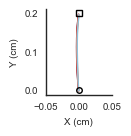

In [72]:
# Assuming neuron_states_dict, exemplar_network_id, and total_neurons are defined
total_neurons = 100
# Number of conditions
num_conditions = len(args.task_condition)




sns.set(style="white")

# Define a diverging colormap from Matplotlib
cmap = plt.get_cmap('seismic')

# Set global linewidth
# Style the Plot
plt.rcParams.update({
    "font.size": 7,
    "font.family": "Arial",
    "axes.labelsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    'lines.linewidth': 1,
    'axes.linewidth': 1,
    'xtick.major.width': 0.8,
    'xtick.minor.width': 0.8,
    'ytick.major.width': 0.8,
    'ytick.minor.width': 0.8,
    'xtick.major.size': 2.,  # Major xtick length
    'ytick.major.size': 2.,  # Minor xtick length
    "axes.titlesize": 7,  # Title font size
    "axes.titleweight": "bold",  # Title font weight
})


# Extract num_conditions evenly spaced colors from the colormap
extracted_colors = cmap(np.linspace(0, 1, num_conditions, endpoint=False))




# Setup the figure size
# convert fig size to mm
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize = (3.5*cm, 3.5*cm))

# Define the grid size (rows, cols) for subplot2grid
grid_size = (2, 1)  # For example, a 4x2 grid

# in the second column of the figure plot the body state spanning the first two rows
ax = plt.subplot2grid(grid_size, (0, 0), rowspan=2, fig=fig)
for j in range(num_conditions):
    ax.plot(body_states_dict[exemplar_network_id][:, j, 0], body_states_dict[exemplar_network_id][:, j, 4], color=colors[j])
sns.despine(ax=ax, left=False, bottom=False)
ax.plot(0, 0, marker='o', markersize=4, markerfacecolor='none', markeredgecolor='black')
ax.plot(0, 0.2, marker='s', markersize=4, markerfacecolor='none', markeredgecolor='black')
#ax.plot(0, 0.2, marker='s', markersize=10, markerfacecolor='none', markeredgecolor='black')
#from matplotlib.patches import Rectangle
# Assuming x0, y0 are the bottom-left coordinates and x1, y1 are the top-right coordinates of the rectangle
#x0, y0 = -0.01, 0.21
#x1, y1 = 0.05, 0.20 # Example coordinates

# Calculate width and height of the rectangle
#width = x1 - x0
#height = y1 - y0

# Create a rectangle patch
#rect = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='black', facecolor='none')

# Add the rectangle to the plot
#ax.add_patch(rect)

ax.set_xlim(-0.05, 0.05)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')








plt.tight_layout()
plt.show()

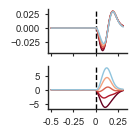

In [73]:
# Setup the figure size
# convert fig size to mm
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize = (3.5*cm, 3.5*cm))

# Define the grid size (rows, cols) for subplot2grid
grid_size = (2, 1)  # For example, a 4x2 grid



# in the second column and the third row plot the body state index 3
ax = plt.subplot2grid(grid_size, (0, 0), fig=fig)
# Draw a vertical line at t=103 for the "GO" signal on each subplot
ax.axvline(x=50, color='black', linestyle='--')
ax.set_xticks([0, 25, 50, 75])
ax.set_xticklabels(['0', '-0.25', '0', '0.25'])
for j in range(num_conditions):
    ax.plot(body_states_dict[exemplar_network_id][53:135, j, vel_plot_index], color=colors[j])
    #ax.plot(body_states_dict[exemplar_network_id][50:, j, 1], color=colors[j], linestyle='--')
#ax.set_ylabel('vel')
# Customize spines after sns.despine()
sns.despine(ax=ax, left=False, bottom=False)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set the position of the bottom and left spines to be decoupled (floating)
# For example, setting them to cross at y=0 and x=0.5 (in data coordinates)
ax.tick_params(labelbottom=False, bottom=True,labelleft=True, left=True)
# Set ticks to be inside and visible
#ax.tick_params(direction='in', length=6, width=2, colors='black', grid_color='black', grid_alpha=0.5)
#ax.set_ylim(vel_ylim[0], vel_ylim[1])



# in the second column and the third row plot the body state index 3
ax = plt.subplot2grid(grid_size, (1, 0), fig=fig)
# Draw a vertical line at t=103 for the "GO" signal on each subplot
ax.axvline(x=50, color='black', linestyle='--')
ax.set_xticks([0, 25, 50, 75])
ax.set_xticklabels(['-0.5', '-0.25', '0', '0.25'])
for j in range(num_conditions):
    ax.plot(body_states_dict[exemplar_network_id][53:135, j, force_plot_index], color=colors[j])
    #ax.plot(body_states_dict[exemplar_network_id][50:, j, 2], color=colors[j], linestyle='--')
#ax.set_ylabel('force')
# Customize spines after sns.despine()
sns.despine(ax=ax, left=False, bottom=False)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set the position of the bottom and left spines to be decoupled (floating)
# For example, setting them to cross at y=0 and x=0.5 (in data coordinates)
#ax.spines['bottom'].set_position(('data', -20))
ax.tick_params(labelbottom=True, bottom=True,labelleft=True, left=True)
# Set ticks to be inside and visible
#ax.tick_params(direction='in', length=6, width=2, colors='black', grid_color='black', grid_alpha=0.5)
#ax.set_ylim(-10, 10)


#ax.set_xlabel('time')

plt.tight_layout()
plt.show()

# save the figure to svg file and png file
#fig.savefig(f'D:/Manuscripts/Writing and notes/NeuralOFC/Figures/svg_raw/{figure_file}_kinematics.svg', dpi=300)
#fig.savefig(f'D:/Manuscripts/Writing and notes/NeuralOFC/Figures/svg_raw/{figure_file}_kinematics.pdf', dpi=300)
#fig.savefig(f'D:/Manuscripts/Writing and notes/NeuralOFC/Figures/png_raw/{figure_file}_kinematics.png', dpi=300)




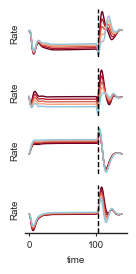

In [74]:
# Setup the figure size
fig = plt.figure(figsize = (3.5*cm, 7*cm))

# Define the grid size (rows, cols) for subplot2grid
grid_size = (4, 1)  # For example, a 4x2 grid



for i in range(4):
    #neuron_index = np.random.randint(0, total_neurons)
    neuron_index = neuron_indices[i]
    # Use subplot2grid to position each subplot
    ax = plt.subplot2grid(grid_size, (i, 0), fig=fig)
    # Use the bright color for each plot from the defined palette
    for j in range(num_conditions):
        ax.plot(neuron_states_dict[exemplar_network_id][:, j, neuron_index], color=colors[j])
    #ax.set_title(f'Neuron {neuron_index}')
    
    ax.tick_params(labelleft=False, left=False)  # Hide y-axis ticks and labels
    
    if i < 3:
        sns.despine(ax=ax, left=True, bottom=True)
        ax.tick_params(labelbottom=False, bottom=False)
    else:
        sns.despine(ax=ax, left=True, bottom=False)
        ax.tick_params(labelbottom=True, bottom=True)
        ax.set_xlabel('Time')

    # Draw a vertical line at t=103 for the "GO" signal on each subplot
    ax.axvline(x=103, color='black', linestyle='--')

    ax.set_ylabel('Rate')
ax.set_xlabel('time')

plt.tight_layout()
plt.show()


# save the figure to svg file and png file
#fig.savefig(f'D:/Manuscripts/Writing and notes/NeuralOFC/Figures/svg_raw/{figure_file}_individualnodes.svg', dpi=300)
#fig.savefig(f'D:/Manuscripts/Writing and notes/NeuralOFC/Figures/svg_raw/{figure_file}_individualnodes.pdf', dpi=300)
#fig.savefig(f'D:/Manuscripts/Writing and notes/NeuralOFC/Figures/png_raw/{figure_file}_individualnodes.png', dpi=300)

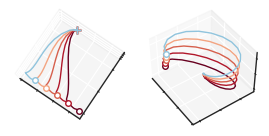

In [75]:
# Setup the figure size
fig = plt.figure(figsize = (7*cm, 3.5*cm))

# Define the grid size (rows, cols) for subplot2grid
grid_size = (1, 2)  # For example, a 4x2 grid


# in the third column of the grid, use rows 1 and 2 to plot the 3D plot of the first three PCs
ax = plt.subplot2grid(grid_size, (0, 0), rowspan=1, fig=fig, projection='3d')
for j in range(num_conditions):
    ax.plot3D(pc_data_prep[:, j, 0], pc_data_prep[:, j, 1], pc_data_prep[:, j, 2], color=colors[j])
    ax.plot3D(pc_data_prep[0, j, 0], pc_data_prep[0, j, 1], pc_data_prep[0, j, 2], '+', markersize=6, markerfacecolor='white', markeredgecolor=colors[j])
    ax.plot3D(pc_data_prep[-1, j, 0], pc_data_prep[-1, j, 1], pc_data_prep[-1, j, 2], 'o', markersize=4, markerfacecolor='white', markeredgecolor=colors[j])
# remove gridlines
ax.grid(False)
#ax.view_init(elev=40, azim=-50, roll=40)  # Adjust view here
#elev_azim_prep = [0, -50]  # Adjust view here
ax.view_init(elev = elev_azim_prep[0], azim = elev_azim_prep[1])
#ax.set_xlabel('PC1')
#ax.set_ylabel('PC2')
#ax.set_zlabel('PC3')
ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)  # Hide y-axis ticks labels
# Customize grid lines
ax.grid(True)
ax.xaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.8)
ax.yaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.8)
ax.zaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.8)


# in the third column of the grid, use rows 1 and 2 to plot the 3D plot of the first three PCs
ax = plt.subplot2grid(grid_size, (0, 1), rowspan=1, fig=fig, projection='3d')
for j in range(num_conditions):
    #if task == 'dotbar':
    #    ax.plot3D(pc_data_perturbed[:, j, 0], pc_data_perturbed[:, j, 1], pc_data_perturbed[:, j, 2], color=colors[j])
    #    ax.plot3D(pc_data_perturbed[0, j, 0], pc_data_perturbed[0, j, 1], pc_data_perturbed[0, j, 2], 'o', markersize=4, markerfacecolor='white', markeredgecolor=colors[j])
    #else:
    ax.plot3D(pc_data[:20, j, 0], pc_data[:20, j, 1], pc_data[:20, j, 2], color=colors[j])
    ax.plot3D(pc_data[0, j, 0], pc_data[0, j, 1], pc_data[0, j, 2], 'o', markersize=4, markerfacecolor='white', markeredgecolor=colors[j])
    # Add arrow at the end of the trajectory
    ax.quiver(
        pc_data[18, j, 0], pc_data[18, j, 1], pc_data[18, j, 2],  # Starting point
        pc_data[19, j, 0] - pc_data[18, j, 0],  # Direction in x
        pc_data[19, j, 1] - pc_data[18, j, 1],  # Direction in y
        pc_data[19, j, 2] - pc_data[18, j, 2],  # Direction in z
        color=colors[j], arrow_length_ratio=0.7
    )

# remove gridlines
# Adjust gridlines to be gray and minimal
# Remove default gridlines
ax.view_init(elev = elev_azim_mov[0], azim = elev_azim_mov[1])
## in the third column of the grid, use rows 3 and 4 to plot the 3D plot of the first two PCs and the first dPCA projection
#ax = plt.subplot2grid(grid_size, (2, 2), rowspan=2, fig=fig, projection='3d')
#for j in range(num_conditions):
#    ax.plot3D(pc_data[:20, j, 0], pc_data[:20, j, 1], dpca_data['ts'][0, :20, j], color=colors[j])
#    ax.plot3D(pc_data[0, j, 0], pc_data[0, j, 1], dpca_data['ts'][0, 0, j], 's', markersize=2, markerfacecolor='white', markeredgecolor=colors[j])
## remove gridlines
#ax.grid(False)
#ax.view_init(elev=50, azim=-150)  # Adjust view here
#ax.set_xlabel('PC1')
#ax.set_ylabel('PC2')
#ax.set_zlabel('PC3')
ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)  # Hide y-axis ticks labels
# Customize grid lines
ax.grid(True)
ax.xaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.8)
ax.yaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.8)
ax.zaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.8)






plt.tight_layout()
plt.show()


# save the figure to svg file and png file
#fig.savefig(f'D:/Manuscripts/Writing and notes/NeuralOFC/Figures/svg_raw/{figure_file}_pca.svg', dpi=300)
#Fig.savefig(f'D:/Manuscripts/Writing and notes/NeuralOFC/Figures/svg_raw/{figure_file}_pca.pdf', dpi=300)
#fig.savefig(f'D:/Manuscripts/Writing and notes/NeuralOFC/Figures/png_raw/{figure_file}_pca.png', dpi=300)


import pickle

# Save the figure to a pickle file
#with open('D:/Manuscripts/Writing and notes/NeuralOFC/Figures/pickle_raw/figure_pca.pkl', 'wb') as f:
#    pickle.dump(fig, f)

In [76]:
# Assuming all_pc_data and all_dpca_data are dictionaries containing PCA and dPCA data for all networks
# Initialize lists to store path length differences for all networks

all_path_lengths_diff = []
max_dims = 3

# Iterate over all networks
for network_id in all_pc_data.keys():
    pc_data_current = all_pc_data[network_id]

    
    # Extract the first two PCs
    lowd_pc_states_ffdyn = pc_data_current[:, :, :max_dims]  # Assuming pc_data is shaped as [T, S, N]
    
    # Compute path length differences for PCA and dPCA data
    path_lengths_diff = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            path_lengths_diff[i, j] = np.sum(np.sqrt(np.sum(np.diff(lowd_pc_states_ffdyn[:, [i, j], :], axis=1)**2, axis=2)))
    
    # Store the path length differences for this network
    all_path_lengths_diff.append(path_lengths_diff[0, :])  # Assuming interest in specific comparison

# Convert lists to arrays for easier mean and standard error computation
all_path_lengths_diff = np.array(all_path_lengths_diff)

# Calculate mean and standard error
mean_path_lengths_diff = np.mean(all_path_lengths_diff, axis=0)
stderr_path_lengths_diff = np.std(all_path_lengths_diff, axis=0) / np.sqrt(all_path_lengths_diff.shape[0])


In [77]:
initial_time_diff_pca = []


# Iterate over all networks
for network_id in all_pc_data_prep.keys():
    pc_data_current = all_pc_data_prep[network_id][-1, :, :max_dims]  # Extract initial time points for the first three PCs
    # reshape dpca_data to match the shape of pc_data
    
    # Compute differences with the 0th level
    diff_pca = np.linalg.norm(pc_data_current - pc_data_current[0, :], axis=1)
    
    # Store the differences
    initial_time_diff_pca.append(diff_pca)

# Convert lists to arrays for easier mean and standard error computation
initial_time_diff_pca = np.array(initial_time_diff_pca)

# Calculate mean and standard error for PCA and dPCA
mean_initial_time_diff_pca = np.mean(initial_time_diff_pca, axis=0)
stderr_initial_time_diff_pca = np.std(initial_time_diff_pca, axis=0) / np.sqrt(initial_time_diff_pca.shape[0]) 



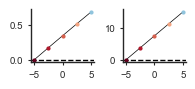

In [78]:

fig = plt.figure(figsize = (5*cm, 2.3*cm))
#fig = plt.figure(figsize=(6, 3))
grid_size = (1, 2)


# Create the first subplot for mean_initial_time_diff
ax1 = plt.subplot2grid(grid_size, (0, 0))
#line1 = ax1.errorbar(fflevels, mean_initial_time_diff_pca, yerr=stderr_initial_time_diff_pca, color='#17becf', fmt='-o', markersize=2) # olive green color
#line2 = ax1.errorbar(fflevels, mean_initial_time_diff_dpca, yerr=stderr_initial_time_diff_dpca, color='gray', fmt='-o', markersize=2)
#ax1.set_title('Preparatory states')
#ax1.set_xlabel('lateral constraint')
#ax1.set_ylabel('distance')
if logplot == 'True':
    ax1.set_xscale('log')
ax1.plot(fflevels, mean_initial_time_diff_pca, color='black',linewidth=0.5)
for i in range(len(fflevels)):
    ax1.errorbar(fflevels[i], mean_initial_time_diff_pca[i], yerr=stderr_initial_time_diff_pca[i], color=colors[i % len(colors)], fmt='-o', markersize=2, label=f'Condition {i+1}')

sns.despine(ax=ax1, left=False, bottom=False)
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(labelbottom=True, bottom=True,labelleft=True, left=True)
ax1.axhline(0, linestyle='--',color='black')

# Create the second subplot for mean_path_lengths_diff
ax2 = plt.subplot2grid(grid_size, (0, 1))
#line3 = ax2.errorbar(fflevels, mean_path_lengths_diff, yerr=stderr_path_lengths_diff, color='#17becf',fmt='-o', markersize=2, label='max. variance direction')
#line4 = ax2.errorbar(fflevels, mean_path_lengths_diff_dpca, yerr=stderr_path_lengths_diff_dpca, color='gray', fmt='-o', markersize=2, label='policy direction')
# Plot each error bar with a different color
if logplot == 'True':
    ax2.set_xscale('log')
# Plot the black line connecting all points
ax2.plot(fflevels, mean_path_lengths_diff, color='black',linewidth=0.5)
for i in range(len(fflevels)):
    ax2.errorbar(fflevels[i], mean_path_lengths_diff[i], yerr=stderr_path_lengths_diff[i], color=colors[i % len(colors)], fmt='-o', markersize=2, label=f'Condition {i+1}')

sns.despine(ax=ax2, left=False, bottom=False)
# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(labelbottom=True, bottom=True,labelleft=True, left=True)
# plot a horizontal line at 0
ax2.axhline(0, linestyle='--',color='black')

# Adjust layout to prevent overlap
plt.tight_layout()

# Create a legend below the plots
#lines = [line3, line4]
#labels = [line.get_label() for line in lines]
#fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

# Adjust layout again to make room for the legend
#plt.subplots_adjust(bottom=0.2)


# Display the plot
plt.show()

In [79]:
import plotly.graph_objects as go
import numpy as np

# Create an empty figure
fig = go.Figure()


data_projection = pc_data_prep + 0

print(data_projection.shape)

#all_data = np.concatenate([data_projection[103:130, :, 0].flatten(), data_projection[103:130, :, 1].flatten(), data_projection[103:130, :, 2].flatten()])



# Create an empty figure
fig = go.Figure()


# Add line traces for each direction
for i in range(5):
    fig.add_trace(go.Scatter3d(x=data_projection[:, i, 0], 
                               y=data_projection[:, i, 1], 
                               z=data_projection[:, i, 2], 
                               mode='lines',  # Specify lines mode
                               name=f'Line {i}'))  # Optional: name each line for clarity

# Add marker traces for the data values at index 103 for each direction
for i in range(5):
    fig.add_trace(go.Scatter3d(x=[data_projection[0, i, 0]], 
                               y=[data_projection[0, i, 1]], 
                               z=[data_projection[0, i, 2]], 
                               mode='markers',  # Specify markers mode
                               marker=dict(size=5, symbol='circle'),  # Customize marker size and shape
                               name=f'Marker {i}'))  # Optional: name each marker for clarity
    
    fig.add_trace(go.Scatter3d(x=[data_projection[-1, i, 0]], 
                               y=[data_projection[-1, i, 1]], 
                               z=[data_projection[-1, i, 2]], 
                               mode='markers',  # Specify markers mode
                               marker=dict(size=5, symbol='cross'),  # Customize marker size and shape
                               name=f'Marker {i}'))  # Optional: name each marker for clarity
    
# Automatically scale each axis based on its data
# No need to manually set ranges or aspectmode
fig.update_layout(scene=dict(aspectmode='cube'))

fig.show()


(90, 5, 6)


In [80]:









# save 

Below I will compute the principal components of the data currently in the shape (T, C, N) where T is the time length, C is the direction of movement, and N is the number of neuron states (orig dimensions).

First we rearrange the data into (CT, N) where CT is the number of observations and N is the number of orginal dimenions/states. The compute the mean centerd data at axis=0 (i.e., at CT axis), and then divide by the max across axis=0

Then we will find the covariance matrix (N by N).

We will compute the eigen vectors and singular values.

Then we will project the mean centered data onto the eigen vectors using @

Then we will restore the dimensions from the original form (T, C, N)